In [18]:
import pyarrow.parquet as pq
import pandas as pd
from concurrent import futures
#from tqdm import tqdm
import os
import json
import time
import gc
import matplotlib.pyplot as plt
import matplotlib.style as psl
%matplotlib inline

%config InlineBakend.figure_format = 'svg'
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.sans-serif"]=["Microsoft YaHei"]
psl.use('ggplot')

In [3]:
def apply(file_names,operation,batchsize):
    """
        处理单行或是多行数据，输出为Series或是Dataframe
    """
    def file_process(file_name):
        """
            内函数，定义单个处理过程
        """
        assert os.path.exists(file_name),f"文件{file_name}访问错误"
        assert file_name.endswith('.parquet'),f"文件{file_name}格式错误"
        file_data = pq.ParquetFile(file_name)
        results = []
        for batch in file_data.iter_batches(batch_size = batchsize):
            df = batch.to_pandas()
            result = operation(df)
            results.append(result)
        results = pd.concat(results,axis=0)
        return results
    workers = min(20,len(file_names))
    with futures.ThreadPoolExecutor(workers) as executor:
        results = executor.map(file_process,file_names)
    all_results = pd.concat(results,axis=0)
    # 此处按照第一列进行分组求和
    result = all_results.groupby(list(all_results.columns[:-1]))[all_results.columns[-1]].sum()
    result = result.reset_index()
    return result
file_names_1G = [f'./data/1G_data/part-000{x:02d}.parquet' for x in range(8)]
file_names_10G = [f'./data/10G_data/part-000{x:02d}.parquet' for x in range(8)]
file_names_30G = [f'./data/30G_data/part-000{x:02d}.parquet' for x in range(16)]


### 数据可视化
#### 性别分析

In [4]:
file_ana = file_names_10G

In [5]:
def gender_amount_data(df):
    gender = df["gender"]
    purchase = df["purchase_history"]
    amount_list = []
    for i in purchase:
        item = json.loads(i)
        amount_list.append(len(item['items'])*item['avg_price'])
    amount = pd.Series(amount_list,name="amount")
    df = pd.concat([gender,amount],axis=1)
    result = df.groupby('gender')['amount'].sum().reset_index()
    return result
start = time.time()
gender_df = apply(file_ana,gender_amount_data,100000)
end = time.time()
gender_time = end-start
print(f"Execute time:{gender_time:.2f} seconds.")

Execute time:383.85 seconds.


In [6]:
gender_df

,gender,amount
0,其他,13503400548
1,女,324283237179
2,未指定,13503685670
3,男,324326419300


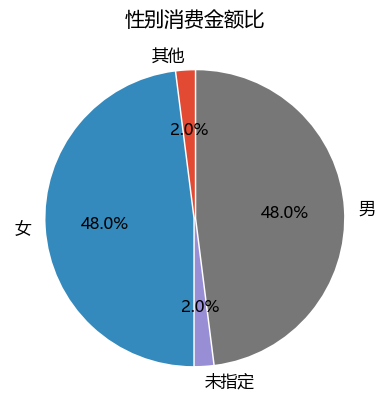

In [ ]:

x = gender_df['amount'].to_list()
labels = gender_df['gender'].to_list()
plt.pie(x,
        labels = labels,
        autopct = '%.1f%%',
        pctdistance = 0.6,
        startangle = 90,
        explode = [0,0.01,0,0.01],
        textprops = {'fontsize':12,'color':'k'}
       )
plt.title("性别消费金额比")
plt.show()

#### 购买类别的金额分布

In [ ]:
def category_amount_data(df):
    purchase_data = df["purchase_history"]
    category_list = []
    amount_list = []
    avg_price = []
    for i in purchase_data:
        item = json.loads(i)
        category_list.append(item['categories'])
        amount_list.append(len(item['items'])*item['avg_price'])
        avg_price.append(item['avg_price'])
    data = {"category":category_list,"amount":amount_list}
    category_data = pd.DataFrame(data)
    result = category_data.groupby('category')['amount'].sum().reset_index()
    return result
start = time.time()
category_df = apply(file_ana,category_amount_data,100000)
end = time.time()
category_time = end-start
print(f"Execute time:{category_time:.2f} seconds.")

Execute time:305.15 seconds.


In [10]:
category_df

,category,amount
0,上衣,16099452339
1,健身器材,16065180765
2,儿童课外读物,16086189200
3,内衣,16076883572
4,办公用品,16129272582
5,卫浴用品,16077402772
6,厨具,16091779293
7,围巾,16092987561
8,外套,16074858181
9,婴儿用品,16097796756


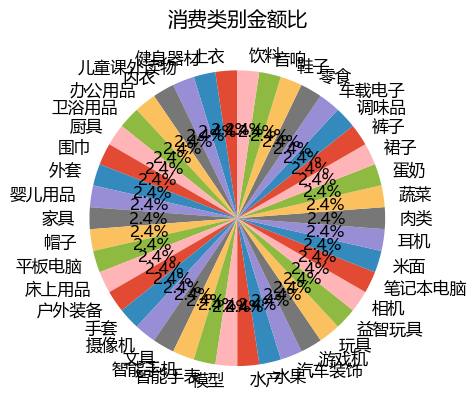

In [19]:
x = category_df['amount'].to_list()
labels = category_df['category'].to_list()
plt.pie(x,
        labels = labels,
        autopct = '%.1f%%',
        pctdistance = 0.6,
        startangle = 90,
        #explode = [0,0.01,0,0.01,0],
        textprops = {'fontsize':12,'color':'k'}
       )
plt.title("消费类别金额比")
plt.show()

#### 收入分布

([0,
  100000,
  200000,
  300000,
  400000,
  500000,
  600000,
  700000,
  800000,
  900000,
  1000000],
 ['0k-100k',
  '100k-200k',
  '200k-300k',
  '300k-400k',
  '400k-500k',
  '500k-600k',
  '600k-700k',
  '700k-800k',
  '800k-900k',
  '900k-1000k'])

In [ ]:
def get_income_data(df):
    purchase = df["purchase_history"]
    income = df["income"]
    income_cut = pd.cut(income,bins=bins,labels=label,right=False)
    income_cut = pd.Series(income_cut,name="income")
    amount_list = []
    for i in purchase:
        item = json.loads(i)
        amount_list.append(len(item['items'])*item['avg_price'])
    amount = pd.Series(amount_list,name="amount")
    df = pd.concat([income_cut,amount],axis=1,ignore_index=True)
    result = df.groupby('income')['amount'].sum().reset_index()
    return result
# 创建收入区间
bins = [i*100000 for i in range(11)]
label = [f"{i*100}k-{(i+1)*100}k" for i in range(10)]
bins,label
start = time.time()
incomes = apply(file_ana,get_income_data,100000)
end = time.time()
income_time = end-start
print(f"Execute time:{income_time:.2f} seconds.")

KeyError: 'income'

In [ ]:
income_cut = pd.Series(pd.qcut(incomes,10),name="income_cut")
income_dis = pd.concat([income_cut,amounts],axis=1)
df_income = income_dis.groupby("income_cut",observed=True)["amount"].sum().reset_index()
income_cut=None
income_dis=None
incomes=None
gc.collect()
df_income

In [ ]:
plt.figure(figsize=(9,6))
x = df_income["income_cut"].astype("str").to_list()
y = df_income["amount"].to_list()

plt.bar(x,y,width=0.5,align="center",label="amount")

plt.title("收入范围金额占比")
for a,b in zip(x,y):
    plt.text(a,b,f"{b/100000000:.1f}亿",ha="center",va="bottom",fontsize=10)
plt.xlabel("收入范围",labelpad=5)
plt.ylabel("交易金额")

plt.xticks(rotation=15,fontsize=9,color='k')#设置X坐标轴刻度
plt.yticks([])
#plt.legend(fontsize=9)
plt.show()
